In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option("max_rows", None)
from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [2]:
from google.cloud import bigquery

In [3]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="./adept-comfort-307720-db5f8ca3ee46.json"
client = bigquery.Client()

In [4]:
%load_ext google.cloud.bigquery

In [5]:
%%bigquery state_2018_5yr
SELECT *
FROM
    `bigquery-public-data.census_bureau_acs.state_2018_5yr`

Downloading: 100%|██████████| 52/52 [00:02<00:00, 25.66rows/s]


In [6]:
 state_2018_5yr.shape

(52, 242)

In [7]:
for col in state_2018_5yr.columns:
    print(col)

geo_id
do_date
total_pop
households
male_pop
female_pop
median_age
male_under_5
male_5_to_9
male_10_to_14
male_15_to_17
male_18_to_19
male_20
male_21
male_22_to_24
male_25_to_29
male_30_to_34
male_35_to_39
male_40_to_44
male_45_to_49
male_50_to_54
male_55_to_59
male_60_to_61
male_62_to_64
male_65_to_66
male_67_to_69
male_70_to_74
male_75_to_79
male_80_to_84
male_85_and_over
female_under_5
female_5_to_9
female_10_to_14
female_15_to_17
female_18_to_19
female_20
female_21
female_22_to_24
female_25_to_29
female_30_to_34
female_35_to_39
female_40_to_44
female_45_to_49
female_50_to_54
female_55_to_59
female_60_to_61
female_62_to_64
female_65_to_66
female_67_to_69
female_70_to_74
female_75_to_79
female_80_to_84
female_85_and_over
white_pop
population_1_year_and_over
population_3_years_over
pop_5_years_over
pop_15_and_over
pop_16_over
pop_25_years_over
pop_25_64
pop_never_married
pop_now_married
pop_separated
pop_widowed
pop_divorced
not_us_citizen_pop
black_pop
asian_pop
hispanic_pop
amerindi

In [8]:
allStates_pop = state_2018_5yr['total_pop'].sum()
average_income =  ((state_2018_5yr['income_per_capita']*state_2018_5yr['total_pop']).sum())/allStates_pop
average_income

32411.262103872632

In [9]:
bins_ = [
    'income_less_10000',
    'income_10000_14999',
    'income_15000_19999',
    'income_20000_24999',
    'income_25000_29999',
    'income_30000_34999',
    'income_35000_39999',
    'income_40000_44999',
    'income_45000_49999',
    'income_50000_59999',
    'income_60000_74999',
    'income_75000_99999',
    'income_100000_124999',
    'income_125000_149999',
    'income_150000_199999',
    'income_200000_or_more'
]
binMiddle = [
    5000,
    12500,
    17500,
    22500,
    27500,
    32500,
    37500,
    42500,
    47500,
    55000,
    67500,
    87500,
    112500,
    137500,
    175000,
    300000
    
]
def median_income(obs):
    household=0
    for idx,bin_ in enumerate(bins_):
        household += obs[bin_]
        if household >= obs['medianPoint']:
            return binMiddle[idx]
        

state_2018_5yr['medianPoint'] = state_2018_5yr['households']/2

state_2018_5yr['stateIncomeMedian'] = state_2018_5yr.apply(lambda row:median_income(row),axis=1)

In [10]:

def medianHouseholdIncomeUS():
    HouseholdBins=[]
    for bin_ in bins_:
        HouseholdBins.append(state_2018_5yr[bin_].sum())
    midPointHouseholds=state_2018_5yr['households'].sum()/2
    medianHouseholds=0
    for idx,households in enumerate(HouseholdBins):
            medianHouseholds+=households
            if medianHouseholds >= midPointHouseholds:
                return binMiddle[idx], HouseholdBins



print(medianHouseholdIncomeUS())

(55000, [7917450.0, 5650451.0, 5610954.0, 5755344.0, 5637788.0, 5626573.0, 5248618.0, 5323160.0, 4694365.0, 9201772.0, 11828929.0, 14983827.0, 10623297.0, 6943175.0, 7523407.0, 8366093.0])


In [11]:
state_2018_5yr['stateIncomeMedian'].skew()

0.4030263027821765

In [12]:
import numpy as np
bins_df = pd.DataFrame(np.column_stack([bins_, binMiddle]), columns=['income_bin', 'bin_avg_income'])
bins_df['bin_avg_income']= bins_df['bin_avg_income'].astype(int)

In [13]:
state_2018_5yr['stateIncomeMedian'].mean()

60913.46153846154

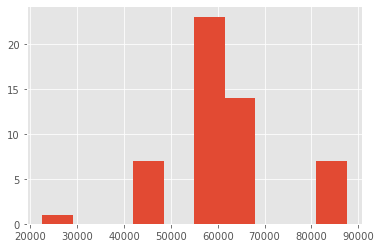

In [14]:
plt.hist(state_2018_5yr['stateIncomeMedian']);


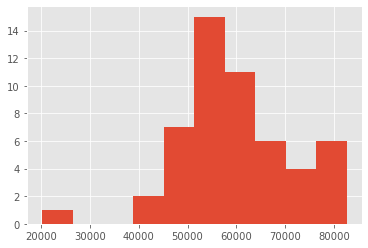

In [15]:
plt.hist(state_2018_5yr['median_income']);

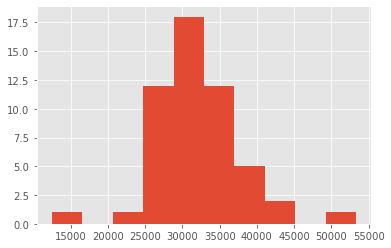

In [16]:
plt.hist(state_2018_5yr['income_per_capita']);

In [17]:
state_2018_5yr['median_income'].skew()

-0.30425115515767487

In [18]:
#Use the avg value of each income bin
state_df = pd.melt(state_2018_5yr, id_vars= ['geo_id','total_pop', 'households','median_income',
                                             'income_per_capita', 'stateIncomeMedian'],
                   value_vars = bins_, var_name = "income_bin", value_name ='households_in_bin')
state_df = pd.merge(state_df, bins_df, on= 'income_bin', how =  'left')

In [19]:
state_df.sample(5)

,geo_id,total_pop,households,median_income,income_per_capita,stateIncomeMedian,income_bin,households_in_bin,bin_avg_income
505,72,3386941.0,1205075.0,20166.0,12451.0,22500,income_50000_59999,61015.0,55000
787,37,10155624.0,3918597.0,52413.0,29456.0,55000,income_200000_or_more,191936.0,300000
633,13,10297484.0,3709488.0,55679.0,29523.0,55000,income_100000_124999,307352.0,112500
230,26,9957488.0,3909509.0,54938.0,30336.0,55000,income_25000_29999,194588.0,27500
393,50,624977.0,259589.0,60076.0,33238.0,67500,income_40000_44999,11121.0,42500


In [20]:
usa_quantiles2 = state_df[['households_in_bin','bin_avg_income']].quantile(
    [.1, .2,.3,.4, .5,.6,.7,.8,.9,1]).reset_index().rename(columns = {'index': 'percentile'})
usa_quantiles2

,percentile,households_in_bin,bin_avg_income
0,0.1,17116.4,12500.0
1,0.2,29978.4,22500.0
2,0.3,47300.7,27500.0
3,0.4,67529.2,37500.0
4,0.5,88452.0,45000.0
5,0.6,113525.0,55000.0
6,0.7,153920.2,87500.0
7,0.8,212694.2,112500.0
8,0.9,331388.5,175000.0
9,1.0,1589511.0,300000.0


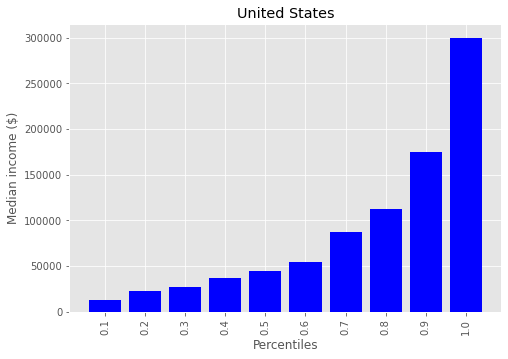

In [21]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(usa_quantiles2['percentile'].astype(str),usa_quantiles2['bin_avg_income'], color="blue")
plt.xticks(rotation=90)
plt.title('United States')
plt.xlabel('Percentiles')
plt.ylabel('Median income ($)')
plt.show()

In [22]:
CA = state_df.loc[(state_df['geo_id'] == '06'), ]
CA_quantiles = CA[['households_in_bin','bin_avg_income']].quantile(
    [.1, .2,.3,.4, .5,.6,.7,.8,.9,1]).reset_index().rename(columns = {'index': 'percentile'})
CA_quantiles


,percentile,households_in_bin,bin_avg_income
0,0.1,487999.5,15000.0
1,0.2,499894.0,22500.0
2,0.3,511611.0,30000.0
3,0.4,536077.0,37500.0
4,0.5,615023.0,45000.0
5,0.6,877148.0,55000.0
6,0.7,981658.0,77500.0
7,0.8,1184505.0,112500.0
8,0.9,1323071.5,156250.0
9,1.0,1589511.0,300000.0


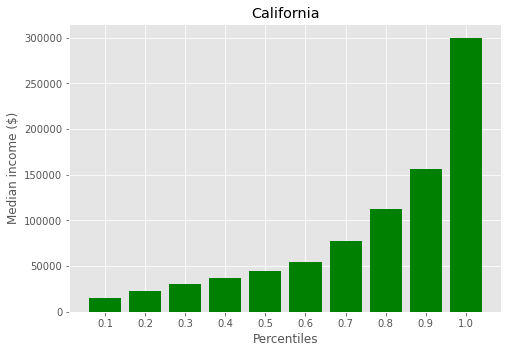

In [23]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(CA_quantiles['percentile'].astype(str),CA_quantiles['bin_avg_income'], color="green")
plt.xlabel('Percentiles')
plt.ylabel('Median income ($)')
plt.title('California')
plt.show()

In [24]:
NY = state_df.loc[(state_df['geo_id'] == '36'), ]
NY_quantiles = NY[['households_in_bin','bin_avg_income']].quantile(
    [.1, .2,.3,.4, .5,.6,.7,.8,.9,1]).reset_index().rename(columns = {'index': 'percentile'})
NY_quantiles


,percentile,households_in_bin,bin_avg_income
0,0.1,277408.5,15000.0
1,0.2,300327.0,22500.0
2,0.3,310251.0,30000.0
3,0.4,325767.0,37500.0
4,0.5,422332.0,45000.0
5,0.6,492299.0,55000.0
6,0.7,523439.5,77500.0
7,0.8,648570.0,112500.0
8,0.9,685578.5,156250.0
9,1.0,868488.0,300000.0


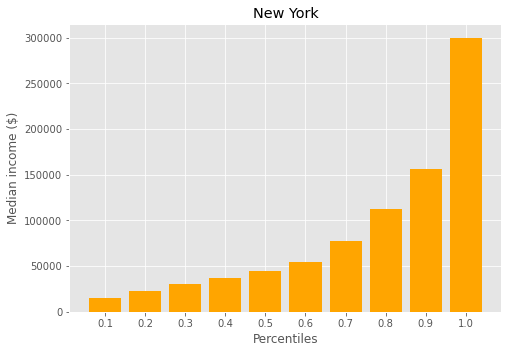

In [25]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(NY_quantiles['percentile'].astype(str),NY_quantiles['bin_avg_income'], color="orange")
plt.xlabel('Percentiles')
plt.ylabel('Median income ($)')
plt.title('New York')
plt.show()

In [26]:
FL = state_df.loc[(state_df['geo_id'] == '12'), ]
FL_quantiles = FL[['households_in_bin','bin_avg_income']].quantile(
    [.1, .2,.3,.4, .5,.6,.7,.8,.9,1]).reset_index().rename(columns = {'index': 'percentile'})
FL_quantiles


,percentile,households_in_bin,bin_avg_income
0,0.1,358263.5,15000.0
1,0.2,368189.0,22500.0
2,0.3,380181.5,30000.0
3,0.4,389340.0,37500.0
4,0.5,406014.0,45000.0
5,0.6,410675.0,55000.0
6,0.7,465831.5,77500.0
7,0.8,592612.0,112500.0
8,0.9,700717.5,156250.0
9,1.0,907315.0,300000.0


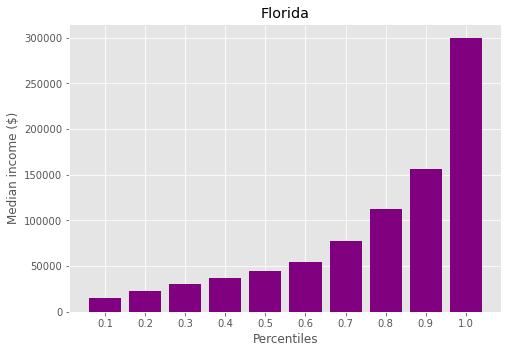

In [27]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(FL_quantiles['percentile'].astype(str),FL_quantiles['bin_avg_income'], color="purple")
plt.xlabel('Percentiles')
plt.ylabel('Median income ($)')
plt.title('Florida')
plt.show()

# Question 2

In [28]:
%%bigquery state_7yrs

SELECT geo_id,
    do_date, 
    income_per_capita, 
    total_pop, 
    households, 
    median_income, 
    income_less_10000,
    income_10000_14999,
    income_15000_19999,
    income_20000_24999,
    income_25000_29999,
    income_30000_34999,
    income_35000_39999,
    income_40000_44999,
    income_45000_49999,
    income_50000_59999,
    income_60000_74999,
    income_75000_99999,
    income_100000_124999,
    income_125000_149999,
    income_150000_199999,
    income_200000_or_more
FROM `bigquery-public-data.census_bureau_acs.state_2012_1yr`
UNION ALL
SELECT geo_id,
    do_date, 
    income_per_capita, 
    total_pop, 
    households, 
    median_income, 
    income_less_10000,
    income_10000_14999,
    income_15000_19999,
    income_20000_24999,
    income_25000_29999,
    income_30000_34999,
    income_35000_39999,
    income_40000_44999,
    income_45000_49999,
    income_50000_59999,
    income_60000_74999,
    income_75000_99999,
    income_100000_124999,
    income_125000_149999,
    income_150000_199999,
    income_200000_or_more
FROM `bigquery-public-data.census_bureau_acs.state_2013_1yr`
UNION ALL
SELECT geo_id,
    do_date, 
    income_per_capita, 
    total_pop, 
    households, 
    median_income, 
    income_less_10000,
    income_10000_14999,
    income_15000_19999,
    income_20000_24999,
    income_25000_29999,
    income_30000_34999,
    income_35000_39999,
    income_40000_44999,
    income_45000_49999,
    income_50000_59999,
    income_60000_74999,
    income_75000_99999,
    income_100000_124999,
    income_125000_149999,
    income_150000_199999,
    income_200000_or_more
FROM `bigquery-public-data.census_bureau_acs.state_2014_1yr`
UNION ALL 
SELECT geo_id,
    do_date, 
    income_per_capita, 
    total_pop, 
    households, 
    median_income, 
    income_less_10000,
    income_10000_14999,
    income_15000_19999,
    income_20000_24999,
    income_25000_29999,
    income_30000_34999,
    income_35000_39999,
    income_40000_44999,
    income_45000_49999,
    income_50000_59999,
    income_60000_74999,
    income_75000_99999,
    income_100000_124999,
    income_125000_149999,
    income_150000_199999,
    income_200000_or_more
FROM `bigquery-public-data.census_bureau_acs.state_2015_1yr`
UNION ALL 
SELECT geo_id,
    do_date, 
    income_per_capita, 
    total_pop, 
    households, 
    median_income, 
    income_less_10000,
    income_10000_14999,
    income_15000_19999,
    income_20000_24999,
    income_25000_29999,
    income_30000_34999,
    income_35000_39999,
    income_40000_44999,
    income_45000_49999,
    income_50000_59999,
    income_60000_74999,
    income_75000_99999,
    income_100000_124999,
    income_125000_149999,
    income_150000_199999,
    income_200000_or_more
FROM `bigquery-public-data.census_bureau_acs.state_2016_1yr`
UNION ALL 
SELECT geo_id,
    do_date, 
    income_per_capita, 
    total_pop, 
    households, 
    median_income, 
    income_less_10000,
    income_10000_14999,
    income_15000_19999,
    income_20000_24999,
    income_25000_29999,
    income_30000_34999,
    income_35000_39999,
    income_40000_44999,
    income_45000_49999,
    income_50000_59999,
    income_60000_74999,
    income_75000_99999,
    income_100000_124999,
    income_125000_149999,
    income_150000_199999,
    income_200000_or_more
FROM `bigquery-public-data.census_bureau_acs.state_2017_1yr`
UNION ALL 
SELECT geo_id, 
    do_date, 
    income_per_capita, 
    total_pop, 
    households, 
    median_income, 
    income_less_10000,
    income_10000_14999,
    income_15000_19999,
    income_20000_24999,
    income_25000_29999,
    income_30000_34999,
    income_35000_39999,
    income_40000_44999,
    income_45000_49999,
    income_50000_59999,
    income_60000_74999,
    income_75000_99999,
    income_100000_124999,
    income_125000_149999,
    income_150000_199999,
    income_200000_or_more
FROM `bigquery-public-data.census_bureau_acs.state_2018_1yr`
ORDER BY do_date;

Downloading: 100%|██████████| 364/364 [00:01<00:00, 183.95rows/s]


In [29]:
state_7yrs.head()

,geo_id,do_date,income_per_capita,total_pop,households,median_income,income_less_10000,income_10000_14999,income_15000_19999,income_20000_24999,income_25000_29999,income_30000_34999,income_35000_39999,income_40000_44999,income_45000_49999,income_50000_59999,income_60000_74999,income_75000_99999,income_100000_124999,income_125000_149999,income_150000_199999,income_200000_or_more
0,23,2012,26020.0,1329192.0,554543.0,46709.0,40809.0,35890.0,33313.0,32597.0,31678.0,35029.0,30362.0,28736.0,23575.0,51055.0,58989.0,65649.0,39139.0,18780.0,14117.0,14825.0
1,50,2012,28818.0,626011.0,258520.0,52977.0,14710.0,15269.0,14479.0,12742.0,12458.0,13743.0,12479.0,13624.0,11717.0,23170.0,28826.0,35307.0,20687.0,11529.0,8966.0,8814.0
2,30,2012,25148.0,1005141.0,408938.0,45076.0,30978.0,26397.0,26074.0,28419.0,24803.0,24000.0,23284.0,20241.0,18027.0,31997.0,45319.0,47108.0,28804.0,13194.0,10750.0,9543.0
3,46,2012,25275.0,833354.0,323765.0,48362.0,20738.0,17490.0,17114.0,19998.0,18474.0,18709.0,19654.0,16770.0,18337.0,28072.0,35529.0,41974.0,21796.0,11680.0,9223.0,8207.0
4,02,2012,31890.0,731449.0,251651.0,67712.0,9859.0,9950.0,10022.0,10979.0,9378.0,11367.0,10863.0,10354.0,9018.0,18717.0,28812.0,35551.0,26651.0,17181.0,18160.0,14789.0


In [30]:
medianHouseholdIncomeUS

<function __main__.medianHouseholdIncomeUS()>

In [31]:
#functions= {bins_: 'sum'}

by_year_df = state_7yrs.groupby('do_date', as_index = False).agg('sum')

#by_year_df = pd.merge(by_year_df, state_7yrs, how = 'left', on = 'do_date')

by_year_df = pd.melt(by_year_df, id_vars= ['geo_id','total_pop', 'households','median_income',
            'income_per_capita'], value_vars = bins_, var_name = "income_bin", value_name ='households_in_bin')
by_year_df.head()

,do_date,income_per_capita,total_pop,households,median_income,income_less_10000,income_10000_14999,income_15000_19999,income_20000_24999,income_25000_29999,income_30000_34999,income_35000_39999,income_40000_44999,income_45000_49999,income_50000_59999,income_60000_74999,income_75000_99999,income_100000_124999,income_125000_149999,income_150000_199999,income_200000_or_more
0,2012,1404725.0,317581124.0,117233234.0,2670147.0,9251859.0,6693558.0,6496817.0,6633628.0,6022085.0,6166412.0,5630064.0,5593215.0,4902533.0,9273321.0,11708373.0,13823737.0,9143880.0,5249757.0,5355943.0,5288052.0
1,2013,1444670.0,319743925.0,117544723.0,2730960.0,9150200.0,6394899.0,6330054.0,6480927.0,5985828.0,6132174.0,5539373.0,5555772.0,4886928.0,9259621.0,11673231.0,13868488.0,9348603.0,5433842.0,5653732.0,5851051.0
2,2014,1479355.0,322405453.0,118492917.0,2796062.0,8903769.0,6310962.0,6214035.0,6365047.0,5900476.0,6034919.0,5552292.0,5506951.0,4872612.0,9265583.0,11738244.0,14141104.0,9631780.0,5729369.0,6052715.0,6273059.0
3,2015,1536769.0,324893003.0,119430101.0,2895371.0,8471821.0,6010793.0,6027298.0,6286144.0,5717018.0,6022623.0,5454120.0,5455027.0,4872219.0,9231734.0,11948008.0,14515810.0,10027855.0,6032402.0,6495731.0,6861498.0
4,2016,1586369.0,326538822.0,120068503.0,2985367.0,8306118.0,5840262.0,5734927.0,6027540.0,5582594.0,5846735.0,5399153.0,5426105.0,4772871.0,9266556.0,11908857.0,14717995.0,10334610.0,6364999.0,6935917.0,7603264.0


In [33]:
1372359.0+991749.0

2364108.0